# 1. Graph Classification Overview

> We will learn how to perform batched graph classification using DGL library. 
>
> The task objective is to classify eight types of graph topologies:
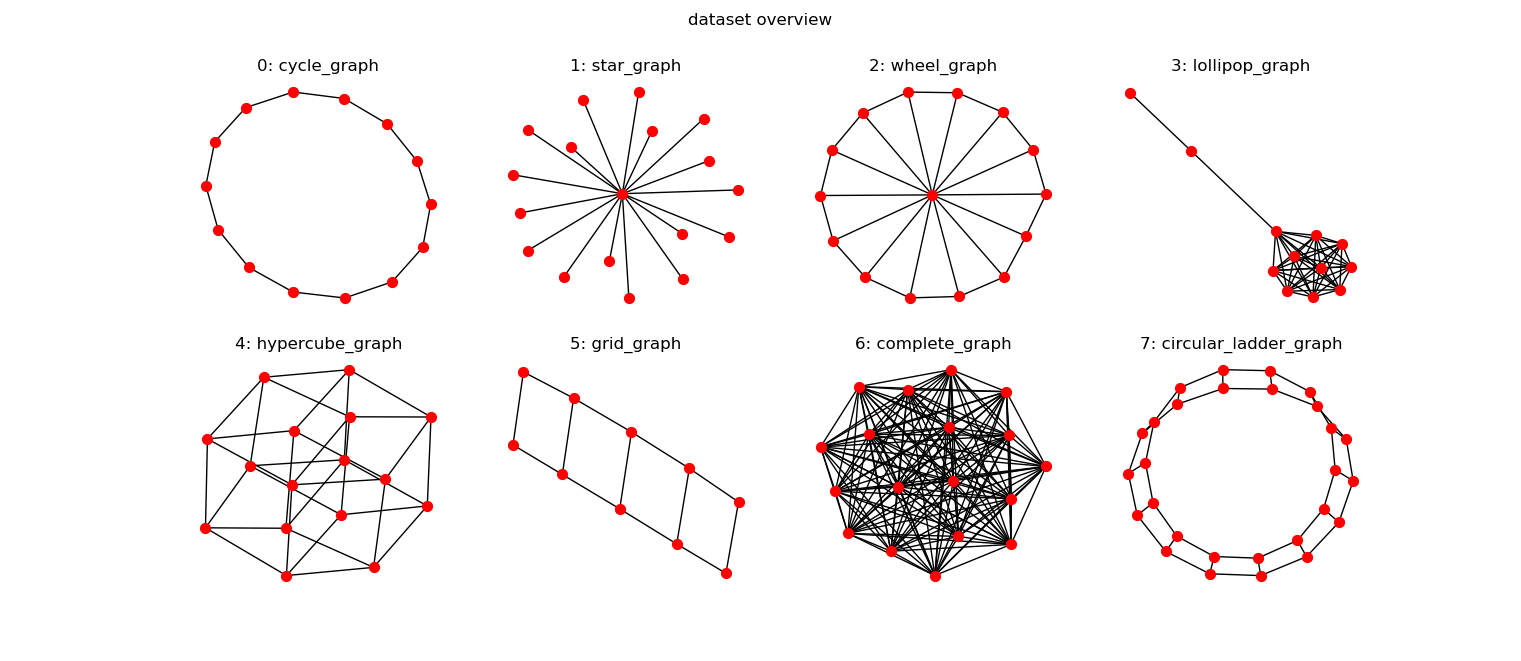
>
> We use a synthetic dataset, _MiniGCDataset_ built in DGL. 

### Install DGL

In [1]:
!pip install dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 239.1 MB 16 kB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 281 kB 16.3 MB/s 
     |████████████████████████████████| 109 kB 59.3 MB/s 
     |████████████████████████████████| 103 kB 51.3 MB/s 
     |████████████████████████████████| 36.8 MB 2.4 MB/s 
     |████████████████████████████████| 78 kB 4.1 MB/s 
     |████████████████████████████████| 45 kB 3.7 MB/s 
     |████████████████████████████████| 51 kB 837 kB/s 
     |████████████████████████████████| 41 kB 476 kB/s 
     |████████████████████████████████| 3.2 MB 55.1 MB/s 
     |████████████████████████████████| 546 kB 57.9 MB/s 
     |████████████████████████████████| 1.1 MB 59.7 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 133 kB

### Import modules

In [2]:
import dgl
from dgl.nn.pytorch import GraphConv
from dgl.data import MiniGCDataset
from dgl.dataloading import GraphDataLoader
import dgl.function as fn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import networkx as nx
import matplotlib.pyplot as plt
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


### Load dataset


In [3]:
# An example dataset with 100 samples, 
# each graph has k nodes, for 10 <= k <= 20
dataset = MiniGCDataset(100, 10, 20)

### Exploring the data statistics (hands-on)



dataset: Dataset("minigc", num_graphs=100, save_path=/root/.dgl/minigc)
the number of data 100
the number of graph: 100
the number of classes: 8
instance data structure: (Graph(num_nodes=15, num_edges=45,
      ndata_schemes={}
      edata_schemes={}), tensor(0))
minimum number of nodes: 10
maximum number of nodes: 20
minimum number of edge: 30
maximum number of edge: 361
mean number of edge: 76.91


(array([12., 12., 12., 12., 12., 12., 12., 16.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <a list of 8 Patch objects>)

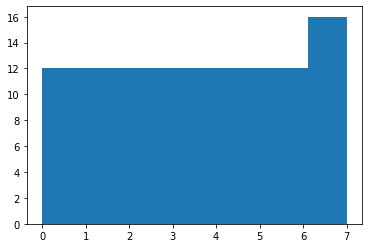

In [7]:
# dataset
print('')
print('dataset:', dataset)
# the number of data
print('the number of data', len(dataset))
# the number of graphs
print('the number of graph:', dataset.num_graphs)
# the number of classes
print('the number of classes:', dataset.num_classes)
# instance data structure
print('instance data structure:', dataset[0])
# minimum number of nodes
print('minimum number of nodes:', dataset.min_num_v)
# maximum number of nodes
print('maximum number of nodes:', dataset.max_num_v)
# minimum number of edges
print('minimum number of edge:', min([dataset[i][0].num_edges() for i in range(len(dataset))]))
# maximum number of edges 
print('maximum number of edge:', max([dataset[i][0].num_edges() for i in range(len(dataset))]))
# mean number of edges 
print('mean number of edge:', sum([dataset[i][0].num_edges() for i in range(len(dataset))]) / len(dataset))
# plotting the histogram for the class distribution
classes = [dataset[i][1].item() for i in range(len(dataset))]
plt.hist(x=classes, bins=dataset.num_classes)

### Plotting graph data

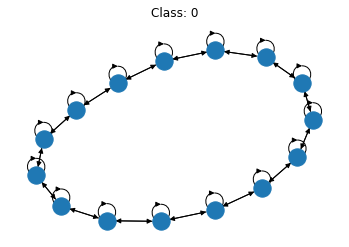

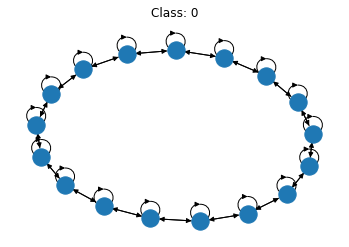

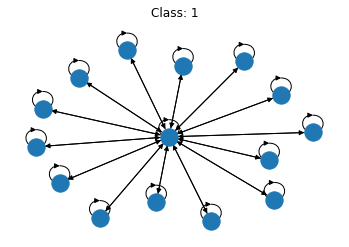

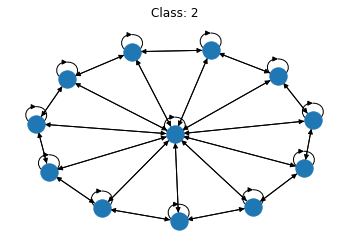

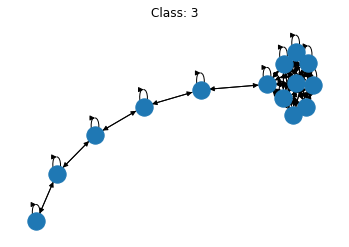

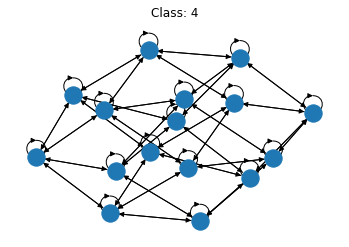

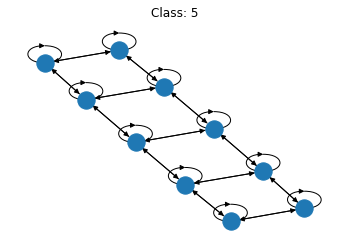

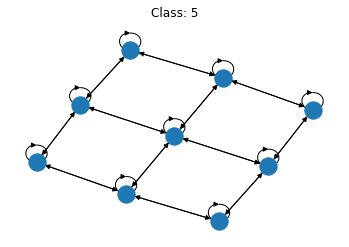

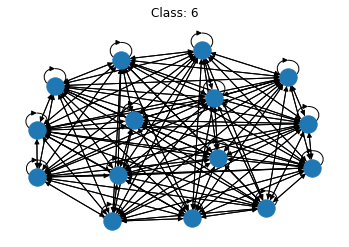

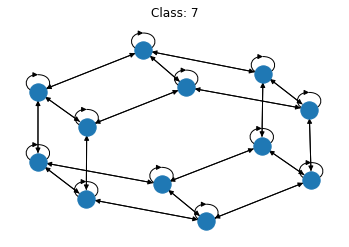

In [8]:
def plot_data(dataset, n):
    graph, label = dataset[n]
    fig, ax = plt.subplots()
    nx.draw(graph.to_networkx(), ax=ax)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()

for i in range(10):    
    plot_data(dataset, i*10)


### Data loader

In [9]:
# Create training and test sets.
trainset = MiniGCDataset(320, 10, 15)
testset = MiniGCDataset(80, 10, 15)

In [10]:
# Use DGL's GraphDataLoader. 
# By default, it supports graph batching.
data_loader = GraphDataLoader(trainset, batch_size=32, shuffle=True)

### Model (hands-on)

In [11]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)# 
        self.conv2 = GraphConv(hidden_dim, hidden_dim)# 
        self.classify = nn.Linear(hidden_dim, n_classes)#

    def forward(self, g):
        # Use node degree as the initial node feature. For undirected graphs, the in-degree
        # is the same as the out_degree.
        h = g.in_degrees().float().view(-1, 1)#
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))#
        h = F.relu(self.conv2(g, h))#
        # Record the latent features in the graph node data
        g.ndata['h'] = h#
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')#
        # Return the output through the linear layer using `self.classify`
        return self.classify(hg)#

In [12]:
# Create model
model = Classifier(1, 256, trainset.num_classes).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train (hands-on)

In [13]:
epoch_losses = []
# set the model in train mode
model.train()
for epoch in range(50):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        # get model output
        prediction = model(bg.to(device))
        # calculate loss
        loss = loss_func(prediction, label.to(device))
        # zero-out gradient from optimizer
        optimizer.zero_grad()
        # backpropagate the loss
        loss.backward()
        # update the weights
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.0703
Epoch 1, loss 2.0003
Epoch 2, loss 1.9918
Epoch 3, loss 1.9786
Epoch 4, loss 1.9663
Epoch 5, loss 1.9585
Epoch 6, loss 1.9506
Epoch 7, loss 1.9292
Epoch 8, loss 1.9076
Epoch 9, loss 1.8772
Epoch 10, loss 1.8423
Epoch 11, loss 1.7946
Epoch 12, loss 1.7501
Epoch 13, loss 1.7006
Epoch 14, loss 1.6484
Epoch 15, loss 1.5884
Epoch 16, loss 1.5312
Epoch 17, loss 1.4708
Epoch 18, loss 1.4050
Epoch 19, loss 1.3483
Epoch 20, loss 1.2922
Epoch 21, loss 1.2339
Epoch 22, loss 1.1864
Epoch 23, loss 1.1310
Epoch 24, loss 1.0838
Epoch 25, loss 1.0469
Epoch 26, loss 1.0129
Epoch 27, loss 0.9845
Epoch 28, loss 0.9521
Epoch 29, loss 0.9280
Epoch 30, loss 0.9328
Epoch 31, loss 0.9031
Epoch 32, loss 0.8757
Epoch 33, loss 0.8478
Epoch 34, loss 0.8445
Epoch 35, loss 0.8306
Epoch 36, loss 0.8076
Epoch 37, loss 0.7890
Epoch 38, loss 0.7820
Epoch 39, loss 0.7688
Epoch 40, loss 0.7570
Epoch 41, loss 0.7486
Epoch 42, loss 0.7390
Epoch 43, loss 0.7276
Epoch 44, loss 0.7080
Epoch 45, loss 0.698

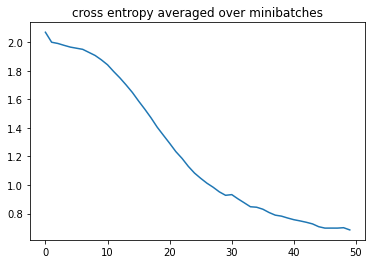

In [14]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

## Test

In [15]:
# set evaluation mode for the model
model.eval()

Classifier(
  (conv1): GraphConv(in=1, out=256, normalization=both, activation=None)
  (conv2): GraphConv(in=256, out=256, normalization=both, activation=None)
  (classify): Linear(in_features=256, out_features=8, bias=True)
)

In [ ]:
testset

### Batching (hands-on)

>  A common practice to learn neural networks efficiently is to group multiple samples into a mini-batch of a fixed-size tensor. For instance, two images of size 128 x 128 can be grouped into a mini-batch tensor of shape 2 x 128 x 128. On the other hand, there are two challenges to batch graph inputs:
> - Graph data is usually sparse, _i.e._, most of the entries in its adjacency matrix is zero.
> -Graphs can have various length, _i.e._, number of nodes and edges is not fixed across instances.
>
> To address this, DGL provides a `dgl.batch()` API. It leverages the idea that a batch of graphs can be viewed as a large graph that has many disjointed connected components. Below is a visualization that gives the general idea.

In [17]:
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))

In [18]:
# print out 10 test input graphs
print(test_X[:10])

[Graph(num_nodes=14, num_edges=42,
      ndata_schemes={}
      edata_schemes={}), Graph(num_nodes=10, num_edges=30,
      ndata_schemes={}
      edata_schemes={}), Graph(num_nodes=13, num_edges=39,
      ndata_schemes={}
      edata_schemes={}), Graph(num_nodes=13, num_edges=39,
      ndata_schemes={}
      edata_schemes={}), Graph(num_nodes=13, num_edges=39,
      ndata_schemes={}
      edata_schemes={}), Graph(num_nodes=11, num_edges=33,
      ndata_schemes={}
      edata_schemes={}), Graph(num_nodes=13, num_edges=39,
      ndata_schemes={}
      edata_schemes={}), Graph(num_nodes=12, num_edges=36,
      ndata_schemes={}
      edata_schemes={}), Graph(num_nodes=14, num_edges=42,
      ndata_schemes={}
      edata_schemes={}), Graph(num_nodes=10, num_edges=30,
      ndata_schemes={}
      edata_schemes={})]


In [19]:
# print out test output classes 
print(torch.stack(test_Y).t())

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7])


In [21]:
# group input graphs into batch
test_bg = dgl.batch(test_X)#

In [22]:
def plot_graph(g):
    fig, ax = plt.subplots()
    nx_g = g.to_networkx()
    nx.draw(nx_g, ax=ax, pos=nx.spring_layout(nx_g))
    plt.show()

batch graph: Graph(num_nodes=900, num_edges=4682,
      ndata_schemes={}
      edata_schemes={})


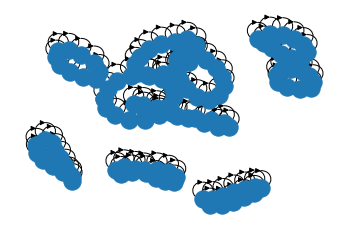

In [23]:
print('batch graph:', test_bg)
# plot batch of 10 graphs
plot_graph(dgl.batch(test_X[:10]))

In [24]:
# type casting and reshaping the label to match the size of the batch input
test_Y = torch.stack(test_Y).float().view(-1, 1)#
print(test_Y.shape)

torch.Size([80, 1])


### Prediction (hands-on)

In [25]:
# model prediction logits from the batch test input
pred = model(test_bg.to(device))#
print('size:', pred.shape)
print('pred:', pred)

size: torch.Size([80, 8])
pred: tensor([[ 1.0876e+01,  3.6360e+00, -5.4320e+00, -2.3254e+00,  2.0871e+00,
          7.3756e+00, -1.4364e+01,  2.0335e+00],
        [ 1.0876e+01,  3.6360e+00, -5.4320e+00, -2.3254e+00,  2.0871e+00,
          7.3756e+00, -1.4364e+01,  2.0335e+00],
        [ 1.0876e+01,  3.6360e+00, -5.4320e+00, -2.3254e+00,  2.0871e+00,
          7.3756e+00, -1.4364e+01,  2.0335e+00],
        [ 1.0876e+01,  3.6360e+00, -5.4320e+00, -2.3254e+00,  2.0871e+00,
          7.3756e+00, -1.4364e+01,  2.0335e+00],
        [ 1.0876e+01,  3.6360e+00, -5.4320e+00, -2.3254e+00,  2.0871e+00,
          7.3756e+00, -1.4364e+01,  2.0335e+00],
        [ 1.0876e+01,  3.6360e+00, -5.4320e+00, -2.3254e+00,  2.0871e+00,
          7.3756e+00, -1.4364e+01,  2.0335e+00],
        [ 1.0876e+01,  3.6360e+00, -5.4320e+00, -2.3254e+00,  2.0871e+00,
          7.3756e+00, -1.4364e+01,  2.0335e+00],
        [ 1.0876e+01,  3.6360e+00, -5.4320e+00, -2.3254e+00,  2.0871e+00,
          7.3756e+00, -1.4364e+01

$\text{Softmax}(y_{i}) = \left(\frac{e^{y_{i}}}{ \sum\limits_{j} e^{y_{j}}}\right), \text{ for }j = 1,...,n$

In [26]:
# compute probability out of model prediction logits using softmax function 
probs_Y = F.softmax(pred, dim=1)#
print('probs_Y:', probs_Y)

probs_Y: tensor([[9.6973e-01, 6.9579e-04, 8.0220e-08, 1.7926e-06, 1.4784e-04, 2.9281e-02,
         1.0594e-11, 1.4013e-04],
        [9.6973e-01, 6.9579e-04, 8.0220e-08, 1.7926e-06, 1.4784e-04, 2.9281e-02,
         1.0594e-11, 1.4013e-04],
        [9.6973e-01, 6.9579e-04, 8.0220e-08, 1.7926e-06, 1.4784e-04, 2.9281e-02,
         1.0594e-11, 1.4013e-04],
        [9.6973e-01, 6.9579e-04, 8.0220e-08, 1.7926e-06, 1.4784e-04, 2.9281e-02,
         1.0594e-11, 1.4013e-04],
        [9.6973e-01, 6.9579e-04, 8.0220e-08, 1.7926e-06, 1.4784e-04, 2.9281e-02,
         1.0594e-11, 1.4013e-04],
        [9.6973e-01, 6.9579e-04, 8.0220e-08, 1.7926e-06, 1.4784e-04, 2.9281e-02,
         1.0594e-11, 1.4013e-04],
        [9.6973e-01, 6.9579e-04, 8.0220e-08, 1.7926e-06, 1.4784e-04, 2.9281e-02,
         1.0594e-11, 1.4013e-04],
        [9.6973e-01, 6.9579e-04, 8.0220e-08, 1.7926e-06, 1.4784e-04, 2.9281e-02,
         1.0594e-11, 1.4013e-04],
        [9.6973e-01, 6.9579e-04, 8.0220e-08, 1.7926e-06, 1.4784e-04, 2.

In [27]:
# sampling from model predicted probabilities using multinomial distribution
sampled_Y = torch.multinomial(probs_Y, 1)#
print('sampled_Y.t():', sampled_Y.t())

sampled_Y.t(): tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 7, 4, 1, 0, 5, 5, 5, 5, 7, 2, 2, 2, 2,
         2, 2, 2, 4, 2, 2, 3, 3, 3, 7, 3, 3, 3, 2, 6, 3, 7, 4, 5, 4, 5, 4, 5, 5,
         4, 1, 5, 4, 5, 7, 4, 5, 5, 5, 4, 5, 3, 6, 6, 6, 3, 6, 6, 6, 6, 6, 4, 5,
         1, 1, 1, 1, 5, 1, 7, 7]], device='cuda:0')


In [28]:
# argmax output from model predicted probabilities
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)#
print('argmax_Y.t():', argmax_Y.t())

argmax_Y.t(): tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 4, 5, 5, 5, 5, 5, 5, 5, 4, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4]], device='cuda:0')


In [29]:
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y.to(device) == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y.to(device) == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 58.7500%
Accuracy of argmax predictions on the test set: 73.750000%


# 2. Inside the Graph Convolutional Network

> How is the neural network learning the representation of the graphs?
>
>         self.conv1 = GraphConv(in_dim, hidden_dim)
> We learn how to implement the Graph Convolutional Network using Pytorch.  
> - Welling, Max, and Thomas N. Kipf. "Semi-supervised classification with graph convolutional networks." J. International Conference on Learning Representations (ICLR 2017). 2016.

### Formal definition

Formally, the node $i$'s embedding $h_i$ computed at $l$-th layer: 

$h_i^{(l+1)}=\sigma\left(b^{(l)}+\sum_{j \in \mathcal{N}(i)} \frac{1}{c_{j i}} h_j^{(l)} W^{(l)}\right)$, 

where $\sigma$ is an activation function,  $\mathcal N(i)$ is a set of nodes in neighborhood of node $i$,

$c_{ji}$ is the product of the square root of node degrees, _i.e._, $c_{ji}=\sqrt{|\mathcal N(j)|}\sqrt{|N(i)|}$,

$W^{(l)}$, and $b^{(l)}$ are weights and bias of the neural network at layer $l$.  

Recall the embedding computed by the usual feedforward neural network is in the following form:

$h^{(l + 1)} = \sigma\left(b^{(l)} + W^{(l)}h^{(l)}\right)$



### Implementation (hands-on)

In [41]:
class SimpleGCN(nn.Module):

    def __init__(self, in_feats, out_feats):
        '''
        ----------
        parameters
        ----------
        in_feats : int
            Input feature size; i.e, the number of dimensions of :math:`h_j^{(l)}`.
        out_feats : int
            Output feature size; i.e., the number of dimensions of :math:`h_i^{(l+1)}`.
        '''
        super(SimpleGCN, self).__init__() 
        self._in_feats = in_feats
        self._out_feats = out_feats
        self.weight = nn.Parameter(torch.FloatTensor(in_feats, out_feats))
        self.bias = nn.Parameter(torch.FloatTensor(out_feats))
        self.reset_parameters_xavier()

    def reset_parameters_xavier(self):
        nn.init.xavier_normal_(self.weight.data, gain=0.02) 
        if self.bias is not None:
            nn.init.constant_(self.bias.data, 0.0)
            
    def forward(self, graph, feat):
        '''
        ----------
        parameters
        ----------
        graph : DGLGraph
            The graph.
        feat : torch.Tensor or pair of torch.Tensor

        -------
        returns
        -------
        torch.Tensor
            The output feature
        '''
        with graph.local_scope():
            # feat.shape: (n_nodes x 1)
            # get out degrees
            out_degs = graph.out_degrees().float().clamp(min=1)# (n_nodes)
            # get normalization of out degrees
            out_norm = torch.pow(out_degs, -0.5).unsqueeze(-1)# (n_nodes x 1)
            # normalize the feature by out_norm
            feat_src = feat * out_norm# (n_nodes x 1) ... elementwise multiplication
            # matmul the feature by the weight
            feat_src = torch.matmul(feat_src, self.weight)# (n_nodes x out_feat_dim)
            # set the graph source data as feat_src
            graph.srcdata['h'] = feat_src

            # Builtin message function that computes a message on an edge 
            # by performing element-wise mul between features of u and e if the features have the same shape; 
            # otherwise, it first broadcasts the features to a new shape and performs the element-wise operation.
            # update the graph: aggregation
            graph.update_all(fn.copy_src('h', 'm'), fn.sum(msg='m', out='h'))

            # get the aggregated features on the nodes
            ret = graph.dstdata['h']# (n_nodes x out_feat_dim)
            # get in degrees
            in_degs = graph.in_degrees().float().clamp(min=1)#
            # get normalization of in degrees
            in_norm = torch.pow(in_degs, -0.5).unsqueeze(-1)# (n_nodes x 1)
            # normalize the output by in_norm
            ret = ret * in_norm# (n_nodes x out_feat_dim)
            # apply the bias
            ret += self.bias#

        return ret


### New Simple Model

In [42]:
class SimpleClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(SimpleClassifier, self).__init__()
        self.conv1 = SimpleGCN(in_dim, hidden_dim)
        self.conv2 = SimpleGCN(hidden_dim, hidden_dim)
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # Use node degree as the initial node feature. 
        # For undirected graphs, the in-degree is the same as the out_degree.
        h = g.in_degrees().view(-1, 1).float()
        # Perform graph convolution and activation function.
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        g.ndata['h'] = h
        # Calculate graph representation by averaging all the node representations.
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

In [43]:
# Create model
model = SimpleClassifier(1, 256, trainset.num_classes).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train with the SimpleGCN

In [44]:
epoch_losses = []
# set the model in train mode
model.train()
for epoch in range(200):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg.to(device))
        loss = loss_func(prediction, label.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 0, loss 2.0770
Epoch 1, loss 2.0494
Epoch 2, loss 1.9961
Epoch 3, loss 1.9581
Epoch 4, loss 1.9239
Epoch 5, loss 1.8779
Epoch 6, loss 1.8243
Epoch 7, loss 1.7704
Epoch 8, loss 1.7222
Epoch 9, loss 1.6759
Epoch 10, loss 1.6315
Epoch 11, loss 1.5818
Epoch 12, loss 1.5296
Epoch 13, loss 1.4741
Epoch 14, loss 1.4152
Epoch 15, loss 1.3370
Epoch 16, loss 1.2710
Epoch 17, loss 1.1900
Epoch 18, loss 1.1152
Epoch 19, loss 1.0547
Epoch 20, loss 0.9991
Epoch 21, loss 0.9592
Epoch 22, loss 0.9202
Epoch 23, loss 0.8776
Epoch 24, loss 0.8622
Epoch 25, loss 0.8326
Epoch 26, loss 0.8208
Epoch 27, loss 0.8112
Epoch 28, loss 0.7846
Epoch 29, loss 0.7804
Epoch 30, loss 0.7538
Epoch 31, loss 0.7540
Epoch 32, loss 0.7664
Epoch 33, loss 0.7181
Epoch 34, loss 0.7095
Epoch 35, loss 0.7040
Epoch 36, loss 0.6936
Epoch 37, loss 0.6791
Epoch 38, loss 0.6716
Epoch 39, loss 0.6640
Epoch 40, loss 0.6540
Epoch 41, loss 0.6724
Epoch 42, loss 0.6520
Epoch 43, loss 0.6587
Epoch 44, loss 0.6530
Epoch 45, loss 0.674

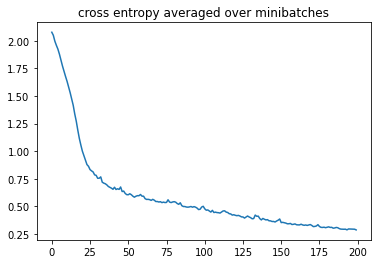

In [45]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

## Test with the SimpleGCN

In [46]:
# set evaluation mode for the model
model.eval()

SimpleClassifier(
  (conv1): SimpleGCN()
  (conv2): SimpleGCN()
  (classify): Linear(in_features=256, out_features=8, bias=True)
)

### Batching

In [47]:
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))

In [48]:
# group input graphs into batch
test_bg = dgl.batch(test_X)

In [49]:
# type casting and reshaping the label to match the size of the batch input
test_Y = torch.stack(test_Y).float().view(-1, 1)
print(test_Y.shape)

torch.Size([80, 1])


### Prediction

In [50]:
# model prediction logits from the batch test input
pred = model(test_bg.to(device))
print(pred.shape)
print('pred:', pred)

torch.Size([80, 8])
pred: tensor([[ 2.4678e+01,  1.3660e+01, -2.0981e+01,  2.8887e+00, -5.1154e+00,
          1.7865e+01, -6.8293e+01, -5.1657e+00],
        [ 2.4678e+01,  1.3660e+01, -2.0981e+01,  2.8887e+00, -5.1154e+00,
          1.7865e+01, -6.8293e+01, -5.1657e+00],
        [ 2.4678e+01,  1.3660e+01, -2.0981e+01,  2.8887e+00, -5.1154e+00,
          1.7865e+01, -6.8293e+01, -5.1657e+00],
        [ 2.4678e+01,  1.3660e+01, -2.0981e+01,  2.8887e+00, -5.1154e+00,
          1.7865e+01, -6.8293e+01, -5.1657e+00],
        [ 2.4678e+01,  1.3660e+01, -2.0981e+01,  2.8887e+00, -5.1154e+00,
          1.7865e+01, -6.8293e+01, -5.1657e+00],
        [ 2.4678e+01,  1.3660e+01, -2.0981e+01,  2.8887e+00, -5.1154e+00,
          1.7865e+01, -6.8293e+01, -5.1657e+00],
        [ 2.4678e+01,  1.3660e+01, -2.0981e+01,  2.8887e+00, -5.1154e+00,
          1.7865e+01, -6.8293e+01, -5.1657e+00],
        [ 2.4678e+01,  1.3660e+01, -2.0981e+01,  2.8887e+00, -5.1154e+00,
          1.7865e+01, -6.8293e+01, -5.1

$\text{Softmax}(y_{i}) = \left(\frac{e^{y_{i}}}{ \sum\limits_{j} e^{y_{j}}}\right), \text{ for }j = 1,...,n$

In [51]:
# compute probability out of model prediction logits using softmax function 
probs_Y = torch.softmax(pred, 1)
probs_Y.shape
print('probs_Y:', probs_Y)

probs_Y: tensor([[9.9889e-01, 1.6386e-05, 1.4798e-20, 3.4407e-10, 1.1494e-13, 1.0983e-03,
         4.1955e-41, 1.0930e-13],
        [9.9889e-01, 1.6386e-05, 1.4798e-20, 3.4407e-10, 1.1494e-13, 1.0983e-03,
         4.1955e-41, 1.0930e-13],
        [9.9889e-01, 1.6386e-05, 1.4798e-20, 3.4407e-10, 1.1494e-13, 1.0983e-03,
         4.1955e-41, 1.0930e-13],
        [9.9889e-01, 1.6386e-05, 1.4798e-20, 3.4407e-10, 1.1494e-13, 1.0983e-03,
         4.1955e-41, 1.0930e-13],
        [9.9889e-01, 1.6386e-05, 1.4798e-20, 3.4407e-10, 1.1494e-13, 1.0983e-03,
         4.1955e-41, 1.0930e-13],
        [9.9889e-01, 1.6386e-05, 1.4798e-20, 3.4407e-10, 1.1494e-13, 1.0983e-03,
         4.1955e-41, 1.0930e-13],
        [9.9889e-01, 1.6386e-05, 1.4798e-20, 3.4407e-10, 1.1494e-13, 1.0983e-03,
         4.1955e-41, 1.0930e-13],
        [9.9889e-01, 1.6386e-05, 1.4798e-20, 3.4407e-10, 1.1494e-13, 1.0983e-03,
         4.1955e-41, 1.0930e-13],
        [9.9889e-01, 1.6386e-05, 1.4798e-20, 3.4407e-10, 1.1494e-13, 1.

In [52]:
# sampling from model predicted probabilities using multinomial distribution
sampled_Y = torch.multinomial(probs_Y, 1)
print('sampled_Y.t():', sampled_Y.t())

sampled_Y.t(): tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 1, 5, 1, 1, 5, 5, 1, 1, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 7, 4, 7, 4, 4, 7, 4, 4,
         7, 4, 5, 5, 5, 5, 7, 1, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4,
         7, 1, 4, 4, 4, 7, 7, 4]], device='cuda:0')


In [53]:
# argmax output from model predicted probabilities
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('argmax_Y.t():', argmax_Y.t())

argmax_Y.t(): tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 1, 1, 5, 1, 1, 5, 1, 1, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4,
         4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4]], device='cuda:0')


In [54]:
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y.to(device) == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y.to(device) == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 77.5000%
Accuracy of argmax predictions on the test set: 82.500000%
